In [624]:
using LinearAlgebra
using DataFrames
using JuMP, Ipopt, Mosek,MosekTools,MathOptInterface

In [625]:
BranchData = DataFrame(From = [ 1, 1, 2, 3, 3, 4], To = [ 2, 3, 4, 4, 5, 5], 
    R = [ 0.0, 0.023, 0.006, 0.020, 0.0, 0.0], X = [ 0.3, 0.145, 0.032, 0.260, 0.320, 0.500], 
    Gsh = [ 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Bsh = [ 0.0, 0.040, 0.010, 0.0, 0.0, 0.0], 
    T = [ 1.0, 1.0, 1.0, 1.0, 0.98,1], Tl = [1.0, 1.0, 1.0, 1.0, 0.95, 1.0], Tu = [1.0, 1.0, 1.0, 1.0, 1.05, 1.0],
    ϕ = [ 0.0, 0.0, 0.0, -3.0, 0.0, 0.0], ϕl = [ 0.0, 0.0, 0.0, -30.0, 0.0, 0.0], ϕu = [ 0.0, 0.0, 0.0, 30.0, 0.0, 0.0]
    );
ZshB = [ 0.0+0.0*im 0.0+0.3*im 0.05+0.0*im 0.0+0.0*im 0.0+0.0*im]; 
GshB = [ 0.0 0.0 0.05 0.0 0.0];
BshB = [ 0.0 0.3 0.0 0.0 0.0];
BusNum = 5;
nLine= nrow(BranchData);
BranchData

,From,To,R,X,Gsh,Bsh,T,Tl,Tu,ϕ
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,2,0.0,0.3,0.0,0.0,1.0,1.0,1.0,0.0
2,1,3,0.023,0.145,0.0,0.04,1.0,1.0,1.0,0.0
3,2,4,0.006,0.032,0.0,0.01,1.0,1.0,1.0,0.0
4,3,4,0.02,0.26,0.0,0.0,1.0,1.0,1.0,-3.0
5,3,5,0.0,0.32,0.0,0.0,0.98,0.95,1.05,0.0
6,4,5,0.0,0.5,0.0,0.0,1.0,1.0,1.0,0.0


In [626]:
R = BranchData.R; X = BranchData.X; Bsh = BranchData.Bsh; T = BranchData.T; ϕ = BranchData.ϕ;
Y = conj((R + X*im).^-1); G = real(Y); B = imag(Y);
insertcols!(BranchData, 4, Y = round.(Y,digits = 3));
insertcols!(BranchData, 5, G = round.(G,digits = 3));
insertcols!(BranchData, 6, B = round.(B,digits = 3));
select!(BranchData, Not(:R));
select!(BranchData, Not(:X));

In [627]:
Y   = Symmetric(sparse(BranchData.From,BranchData.To,BranchData.Y,BusNum,BusNum));
G   = real(Y); B = imag(Y);
Gsh = Symmetric(sparse(BranchData.From,BranchData.To,BranchData.Gsh,BusNum,BusNum));
Bsh = Symmetric(sparse(BranchData.From,BranchData.To,BranchData.Bsh,BusNum,BusNum));

In [629]:
BusData = DataFrame(Bus = [ 1, 2, 3, 4, 5], 
    PL = [ 0.0, 0.0, 0.0, 0.90, 0.239], QL = [ 0.0, 0.0, 0.0, 0.400, 0.129], 
    Vmin = [ 1.0, 0.95, 0.95, 0.95, 0.95], Vmax = [ 1.0, 1.05, 1.05, 1.05, 1.05]
    );
PL   = BusData.PL;
QL   = BusData.QL;
Vmin = BusData.Vmin;
Vmax = BusData.Vmax;

GenData = DataFrame(Bus = [ 1, 2, 3, 4, 5], 
    PGmin = [ 0.0, 0.0, 0.10, 0.05, 0.0], PGmax = [ 1.0, 0.0, 0.40, 0.40, 0.0], 
    QGmin = [ 0.0, 0.0, -0.2, -0.2, 0.0], QGmax = [ 0.4, 0.0, 0.30, 0.20, 0.0]
    );
PgL = GenData.PGmin;
PgU = GenData.PGmax;
QgL = GenData.QGmin;
QgU = GenData.QGmax;

In [494]:
#Create Wi,i/j,j keys
Self = Tuple{Int64,Int64}[]
for i in 1:BusNum+BusNum
    Key = (i,i)
    push!(Self,Key)
end
Self;
#Create Wi,j keys
Trans_Real = collect(keys(y));
#Create Wi+n,j
Trans_Imag = Tuple{Int64,Int64}[]
for (i,j) in collect(keys(y))
    Key2 = (i+BusNum,j)
    push!(Trans_Imag,Key2)
end

R = vcat(Trans_Real,Trans_Imag)
K = vcat(Self,Trans_Real,Trans_Imag)

22-element Array{Tuple{Int64,Int64},1}:
 (1, 1)  
 (2, 2)  
 (3, 3)  
 (4, 4)  
 (5, 5)  
 (6, 6)  
 (7, 7)  
 (8, 8)  
 (9, 9)  
 (10, 10)
 (3, 5)  
 (4, 5)  
 (1, 2)  
 (2, 4)  
 (1, 3)  
 (3, 4)  
 (8, 5)  
 (9, 5)  
 (6, 2)  
 (7, 4)  
 (6, 3)  
 (8, 4)  

In [585]:
model = nothing
model = Model(with_optimizer(Mosek.Optimizer,QUIET=false,MSK_IPAR_INFEAS_REPORT_AUTO=true))

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Mosek

In [586]:
@variable(model, Pg[1:BusNum]);
@variable(model, Qg[1:BusNum]);

In [587]:
@variable(model, W[i = K]                  );

In [588]:
for i in keys(GenBus)
    set_upper_bound(Pg[i], PgU[i]);
    set_lower_bound(Pg[i], PgL[i]);
    set_upper_bound(Qg[i], QgU[i]);
    set_lower_bound(Qg[i], QgL[i]);
end
delete_upper_bound(Pg[2])
delete_lower_bound(Pg[2])
delete_upper_bound(Pg[5])
delete_lower_bound(Pg[5])
fix(Pg[2],0)
fix(Pg[5],0)
delete_upper_bound(Qg[2])
delete_lower_bound(Qg[2])
delete_upper_bound(Qg[5])
delete_lower_bound(Qg[5])
fix(Qg[2],0)
fix(Qg[5],0)

In [589]:
fix(W[(1,1)],1, force = true)

In [590]:
@objective(model, Min, 0.35*Pg[1] + 0.2*Pg[3] + 0.4*Pg[3]*Pg[3] + 0.3*Pg[4] + 0.5*Pg[4]*Pg[4])

0.4 Pg[3]² + 0.5 Pg[4]² + 0.35 Pg[1] + 0.2 Pg[3] + 0.3 Pg[4]

In [591]:
@constraint(model,RI_Con0[ (i,j) = Self],   0  <= W[(i,i)] );
@constraint(model,RI_Con1[ (i,j) = Self],   0  <= W[(j,j)] );
@constraint(model,RI_Con4[ (i,j) = Trans_Real], [ W[(i,j)], 1*W[(i+BusNum,j)],  W[(i,i)],  W[(j,j)]] in RotatedSecondOrderCone());

In [592]:
@constraint(model, V_Con[i = 1:BusNum], Vmin[i]*Vmin[i]<=W[(i,i)]<=Vmax[i]*Vmax[i] ); 

In [593]:
δL = -15*π/180; δU = 15*π/180;
@constraint(model, δL_Con[(i,j) = Trans_Real], tan(δL)*(W[(i,j)])<= W[(i+BusNum,j)] );  
@constraint(model, δU_Con[(i,j) = Trans_Real], W[(i+BusNum,j)] <= tan(δU)*(W[(i,j)]) );     

In [594]:
@expression(model, ActivePFij[(i,j) = Trans_Real], (g[(i,j)]*W[(i,i)]) - (g[(i,j)]*W[(i,j)]) + (-b[(i,j)]*W[(i+BusNum,j)]) );

In [595]:
@expression(model, ActivePFji[(i,j) = Trans_Real], (g[(i,j)]*W[(j,j)]) - (g[(i,j)]*W[(i,j)]) - (-b[(i,j)]*W[(i+BusNum,j)]) );

In [596]:
@constraint(model, ActiveBranch[i = 1:BusNum],Pg[i]-PL[i] == 
sum(ActivePFij[(i,j)] for (i,j) in keys(filter(p -> p.first[1] == i,g))) + 
sum(ActivePFji[(i,j)] for (i,j) in keys(filter(p -> p.first[2] == i,g)))
    );

In [597]:
optimize!(model)
objective_value(model)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 70              
  Cones                  : 7               
  Scalar variables       : 61              
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 70              
  Cones               

0.45652156286964957

In [519]:
collect(values(PL));
ActiveBranch

5-element Array{ConstraintRef{Model,C,Shape} where Shape<:AbstractShape where C,1}:
 ActiveBranch[1] : Pg[1] + 3.333 W[(6, 2)] - 1.067 W[(1, 1)] + 1.067 W[(1, 3)] + 6.727 W[(6, 3)] == 0.0                                    
 ActiveBranch[2] : Pg[2] - 5.66 W[(2, 2)] + 5.66 W[(2, 4)] + 30.189 W[(7, 4)] - 3.333 W[(6, 2)] == 0.0                                     
 ActiveBranch[3] : Pg[3] + 3.125 W[(8, 5)] - 1.361 W[(3, 3)] + 0.294 W[(3, 4)] + 3.824 W[(8, 4)] + 1.067 W[(1, 3)] - 6.727 W[(6, 3)] == 0.0
 ActiveBranch[4] : Pg[4] + 2 W[(9, 5)] - 5.954 W[(4, 4)] + 5.66 W[(2, 4)] - 30.189 W[(7, 4)] + 0.294 W[(3, 4)] - 3.824 W[(8, 4)] == 0.9    
 ActiveBranch[5] : Pg[5] - 3.125 W[(8, 5)] - 2 W[(9, 5)] == 0.239                                                                          

In [545]:
value(Pg[5]) + value(W[(8,5)])*-3.125 + value(W[(9,5)])*-2

-1.2400982761799125e-12

In [600]:
δL_Con

1-dimensional DenseAxisArray{ConstraintRef{Model,C,Shape} where Shape<:AbstractShape where C,1,...} with index sets:
    Dimension 1, Tuple{Int64,Int64}[(3, 5), (4, 5), (1, 2), (2, 4), (1, 3), (3, 4)]
And data, a 6-element Array{ConstraintRef{Model,C,Shape} where Shape<:AbstractShape where C,1}:
 δL_Con[(3, 5)] : -0.2679491924311227 W[(3, 5)] - W[(8, 5)] <= 0.0
 δL_Con[(4, 5)] : -0.2679491924311227 W[(4, 5)] - W[(9, 5)] <= 0.0
 δL_Con[(1, 2)] : -0.2679491924311227 W[(1, 2)] - W[(6, 2)] <= 0.0
 δL_Con[(2, 4)] : -0.2679491924311227 W[(2, 4)] - W[(7, 4)] <= 0.0
 δL_Con[(1, 3)] : -0.2679491924311227 W[(1, 3)] - W[(6, 3)] <= 0.0
 δL_Con[(3, 4)] : -0.2679491924311227 W[(3, 4)] - W[(8, 4)] <= 0.0

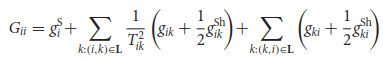

In [386]:
@expression(model, ReActivePFij[(i,j) = Trans_Real], 
  (1/(Tap[(i,j)]*Tap[(i,j)]))*(-b[(i,j)]-bsh[(i,j)]/2                                  )*(W[(i,i)]                ) -
  (1/(Tap[(i,j)]           ))*(-b[(i,j)]*cos(Phase[(i,j)]) - g[(i,j)]*sin(Phase[(i,j)]))*(W[(i,j)]           ) -
  (1/(Tap[(i,j)]           ))*( g[(i,j)]*cos(Phase[(i,j)]) - b[(i,j)]*sin(Phase[(i,j)]))*(W[(i+BusNum,j)]           )
                            );

In [387]:
@expression(model, ReActivePFji[(i,j) = Trans_Real],
                            (-b[(i,j)]-bsh[(i,j)]/2                                  )*(W[(j,j)]                ) -
  (1/(Tap[(i,j)]         ))*( g[(i,j)]*sin(Phase[(i,j)]) - b[(i,j)]*cos(Phase[(i,j)]))*(W[(i,j)]             ) +
  (1/(Tap[(i,j)]         ))*( b[(i,j)]*sin(Phase[(i,j)]) + g[(i,j)]*cos(Phase[(i,j)]))*(W[(i+BusNum,j)]             )
                            );

In [388]:
@constraint(model, ReActiveBranch[i = 1:BusNum],Qg[i]-QL[i] == 
sum(ReActivePFij[(i,j)] for (i,j) in keys(filter(p -> p.first[1] == i,b))) + 
sum(ReActivePFji[(i,j)] for (i,j) in keys(filter(p -> p.first[2] == i,b)))
    );

In [404]:
optimize!(model)
objective_value(model)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 70              
  Cones                  : 7               
  Scalar variables       : 61              
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 70              
  Cones               

0.04024999999899217

In [ ]:
model

In [447]:
P_G = value.(Pg)
Q_G = value.(Qg)
BusResults = DataFrame(Pg = P_G, Qg = Q_G)

,Pg,Qg
,Float64,Float64
1,-2.2542e-12,0.0
2,0.0,0.0
3,0.1,-0.2
4,0.05,-0.2
5,0.0,0.0


In [211]:
value(W[(2,2)])

1.1024999791688326

In [309]:
WR_ = value.(W)
#BranchResults = DataFrame( WR = WR_, WI = WI_) 

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, Tuple{Int64,Int64}[(1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10)  …  (1, 2), (2, 4), (1, 3), (3, 4), (8, 5), (9, 5), (6, 2), (7, 4), (6, 3), (8, 4)]
And data, a 22-element Array{Float64,1}:
  1.0                 
  1.1024999952342072  
  0.9025000033927746  
  1.003565847372876   
  1.1024999979592565  
 -0.0                 
 -0.0                 
 -0.0                 
 -0.0                 
 -0.0                 
  1.4099009902435287  
  0.5127273665108645  
  0.17425745723558203 
  1.201983352079659   
  1.341895577110049   
  0.3458072620124425  
 -0.046815567443898407
 -0.04485783240143266 
  0.015245552777653812
 -0.016968511054689335
  0.06569830236159718 
 -0.030254216082034067

In [390]:
value.(W)

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, Tuple{Int64,Int64}[(1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10)  …  (1, 2), (2, 4), (1, 3), (3, 4), (8, 5), (9, 5), (6, 2), (7, 4), (6, 3), (8, 4)]
And data, a 22-element Array{Float64,1}:
  1.0                  
  1.076652264502454    
  0.9218586173714863   
  0.937416117296632    
  1.059810734044951    
 -0.0                  
 -0.0                  
 -0.0                  
 -0.0                  
 -0.0                  
  1.3749936535317637   
  0.4589919614560778   
  0.9681565306458665   
  1.0869386315269105   
  1.277889352195797    
  0.07761220005609751  
 -0.08682726039634896  
  0.018936320785019535 
 -0.07289107419460866  
 -0.009976043845504413 
 -0.007962240003277277 
  0.0012648722975092145

In [88]:
value.(WijR[(1,2)])

6.704912101524865e-8

In [89]:
value.(WijI[(1,2)])

1.8568942831942616e-8

In [147]:
objective_value(model)

-0.31450767514967165

In [29]:
value.(Pg)

5-element Array{Float64,1}:
 -1.7334976431192735e-15
  0.0                   
  2.2191967367655776e-14
  2.3218602875855338e-14
  0.0                   

In [278]:
W

1-dimensional DenseAxisArray{VariableRef,1,...} with index sets:
    Dimension 1, Tuple{Int64,Int64}[(1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (3, 5), (4, 5), (1, 2), (2, 4), (1, 3), (3, 4), (8, 5), (9, 5), (6, 2), (7, 4), (6, 3), (8, 4)]
And data, a 17-element Array{VariableRef,1}:
 W[(1, 1)]
 W[(2, 2)]
 W[(3, 3)]
 W[(4, 4)]
 W[(5, 5)]
 W[(3, 5)]
 W[(4, 5)]
 W[(1, 2)]
 W[(2, 4)]
 W[(1, 3)]
 W[(3, 4)]
 W[(8, 5)]
 W[(9, 5)]
 W[(6, 2)]
 W[(7, 4)]
 W[(6, 3)]
 W[(8, 4)]

In [286]:
value.(W[(1,3)])

0.0